# Import Dependencies

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPool2D, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

# Check if Tensorflow is Using GPU

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
EPOCHS = 100
Batch_size = 32

train_loc = "Data/train/"
test_loc ="Data/test/"
val_loc = "Data/valid/"

# Data Agumention

In [4]:
trdata = ImageDataGenerator(rescale=1./255, 
                            shear_range=0.2,
                            zoom_range=0.2, 
                            rotation_range=0.2,
                            height_shift_range=0.2,
                            width_shift_range=0.2,
                            horizontal_flip=True, 
                            fill_mode="nearest",
                           )
traindata = trdata.flow_from_directory(
    directory=train_loc, target_size=(224,224), shuffle=True)
tsdata = ImageDataGenerator(rescale=1./255)
testdata = tsdata.flow_from_directory(
    directory=test_loc, target_size=(224,224), shuffle=False)
vdata = ImageDataGenerator(rescale=1./255)
valdata = vdata.flow_from_directory(
    directory=val_loc, target_size=(224,224), shuffle=True)

traindata.class_indices

Found 2339 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


{'AFRICAN LEOPARD': 0,
 'CARACAL': 1,
 'CHEETAH': 2,
 'CLOUDED LEOPARD': 3,
 'JAGUAR': 4,
 'LIONS': 5,
 'OCELOT': 6,
 'PUMA': 7,
 'SNOW LEOPARD': 8,
 'TIGER': 9}

# Build the Model

In [5]:
input_shape = (224,224, 3)
img_input = Input(shape=input_shape, name='ey-image-input')

# Build the model
x = Conv2D(32, (3, 3), padding='same',activation='relu', name='ey-layer_1')(img_input)
x = Conv2D(64, (3, 3), padding='same', activation='relu', name='ey-layer_2')(x)
x = MaxPool2D((2, 2), strides=(2, 2), name='ey-layer_3')(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu', name='ey-layer_4')(x)
x = MaxPool2D((2, 2), strides=(2, 2), name='ey-layer_5')(x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3, 3), padding='same', activation='relu', name='ey-layer_6')(x)
x = MaxPool2D((2, 2), strides=(2, 2), name='ey-layer_7')(x)
x = Dropout(0.25)(x)

x = Conv2D(512, (3, 3), padding='same', activation='relu', name='ey-layer_8')(x)
x = MaxPool2D((2, 2), strides=(2, 2), name='ey-layer_9')(x)
x = Dropout(0.25)(x)

x = Flatten(name='ey-layer_10')(x)
x = Dense(512, activation= 'relu', name='ey-layer_11')(x)
x = Dense(128, activation= 'relu', name='ey-layer_12')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax', name='predections')(x)

# generate the model
model = Model(inputs=img_input, outputs=x, name='ey-cnn')

# print network structure
model.summary()

Model: "ey-cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ey-image-input (InputLayer)  [(None, 224, 224, 3)]    0         
                                                                 
 ey-layer_1 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 ey-layer_2 (Conv2D)         (None, 224, 224, 64)      18496     
                                                                 
 ey-layer_3 (MaxPooling2D)   (None, 112, 112, 64)      0         
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 ey-layer_4 (Conv2D)         (None, 112, 112, 128)     73856     
                                                                 
 ey-layer_5 (MaxPooling2D)   (None, 56, 56, 128)       0    

# Compile Model

In [6]:
print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-4, decay= 1e-5)
model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

my_callbacks = [EarlyStopping(monitor="val_loss", 
                              patience=15, 
                              verbose=1, 
                              mode="auto"),
                ModelCheckpoint(filepath="./models/best_model_BIGCATS.h5",
                                monitor= 'val_loss', 
                                verbose= 1,
                                save_best_only= True, 
                                mode = 'auto')
               ]

[INFO] compiling model...


# Fit the model

In [7]:
print("[INFO] training ...")
hist = model.fit(
    traindata, 
    batch_size=Batch_size,
    steps_per_epoch=traindata.samples // Batch_size,
    validation_steps=valdata.samples // Batch_size,
    epochs=EPOCHS,
    callbacks=my_callbacks,
    validation_data=valdata
)

[INFO] training ...
Epoch 1/100
73/73 [==============================] - ETA: 0s - loss: 2.3111 - accuracy: 0.0975
Epoch 1: val_loss improved from inf to 2.29269, saving model to ./models\best_model_BIGCATS.h5
73/73 [==============================] - 27s 313ms/step - loss: 2.3111 - accuracy: 0.0975 - val_loss: 2.2927 - val_accuracy: 0.2188
Epoch 2/100
73/73 [==============================] - ETA: 0s - loss: 2.2612 - accuracy: 0.1461
Epoch 2: val_loss improved from 2.29269 to 2.19475, saving model to ./models\best_model_BIGCATS.h5
73/73 [==============================] - 25s 336ms/step - loss: 2.2612 - accuracy: 0.1461 - val_loss: 2.1948 - val_accuracy: 0.2188
Epoch 3/100
73/73 [==============================] - ETA: 0s - loss: 2.1244 - accuracy: 0.2046
Epoch 3: val_loss improved from 2.19475 to 1.87129, saving model to ./models\best_model_BIGCATS.h5
73/73 [==============================] - 25s 343ms/step - loss: 2.1244 - accuracy: 0.2046 - val_loss: 1.8713 - val_accuracy: 0.4062
Epoch 

73/73 [==============================] - ETA: 0s - loss: 1.1686 - accuracy: 0.5609
Epoch 28: val_loss did not improve from 0.99860
73/73 [==============================] - 20s 274ms/step - loss: 1.1686 - accuracy: 0.5609 - val_loss: 1.0440 - val_accuracy: 0.5312
Epoch 29/100
73/73 [==============================] - ETA: 0s - loss: 1.1084 - accuracy: 0.5904
Epoch 29: val_loss did not improve from 0.99860
73/73 [==============================] - 20s 275ms/step - loss: 1.1084 - accuracy: 0.5904 - val_loss: 1.1279 - val_accuracy: 0.5938
Epoch 30/100
73/73 [==============================] - ETA: 0s - loss: 1.0934 - accuracy: 0.5977
Epoch 30: val_loss did not improve from 0.99860
73/73 [==============================] - 20s 273ms/step - loss: 1.0934 - accuracy: 0.5977 - val_loss: 1.0867 - val_accuracy: 0.5312
Epoch 31/100
73/73 [==============================] - ETA: 0s - loss: 1.0926 - accuracy: 0.5956
Epoch 31: val_loss improved from 0.99860 to 0.97578, saving model to ./models\best_model_

Epoch 57/100
73/73 [==============================] - ETA: 0s - loss: 0.8571 - accuracy: 0.6931
Epoch 57: val_loss did not improve from 0.72572
73/73 [==============================] - 20s 274ms/step - loss: 0.8571 - accuracy: 0.6931 - val_loss: 0.8149 - val_accuracy: 0.6250
Epoch 58/100
73/73 [==============================] - ETA: 0s - loss: 0.8026 - accuracy: 0.7070
Epoch 58: val_loss did not improve from 0.72572
73/73 [==============================] - 20s 274ms/step - loss: 0.8026 - accuracy: 0.7070 - val_loss: 0.8090 - val_accuracy: 0.6875
Epoch 59/100
73/73 [==============================] - ETA: 0s - loss: 0.7459 - accuracy: 0.7321
Epoch 59: val_loss did not improve from 0.72572
73/73 [==============================] - 20s 274ms/step - loss: 0.7459 - accuracy: 0.7321 - val_loss: 0.7549 - val_accuracy: 0.6250
Epoch 60/100
73/73 [==============================] - ETA: 0s - loss: 0.7380 - accuracy: 0.7295
Epoch 60: val_loss did not improve from 0.72572
73/73 [=====================

# Accuracy & Loss curves


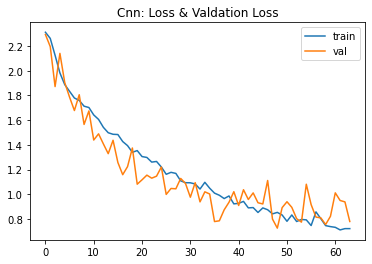

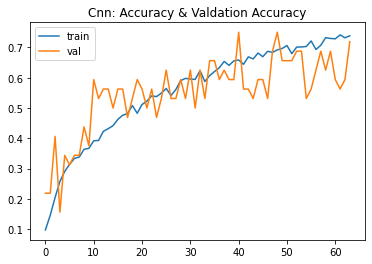

2/2 [==============================] - 1s 474ms/step


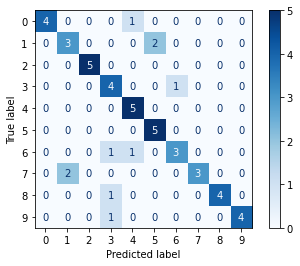

In [8]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('Cnn: Loss & Valdation Loss')
plt.legend()
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('Cnn: Accuracy & Valdation Accuracy')
plt.legend()
plt.show()

target_names = ["AFRICAN LEOPARD","CARACAL","CHEETAH","CLOUDED LEOPARD","JAGUAR","LIONS","OCELOT","PUMA","SNOW LEOPARD","TIGER"]
labels_names =[0,1,2,3,4,5,6,7,8,9]

Y_pred = model.predict(testdata)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(testdata.classes, y_pred, labels=labels_names)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
disp = disp.plot(cmap=plt.cm.Blues)

plt.show()


In [11]:
model = load_model("models/best_model_BIGCATS.h5")
model.evaluate(testdata)

2/2 [==============================] - 0s 29ms/step - loss: 0.6048 - accuracy: 0.8000


[0.6047559380531311, 0.800000011920929]

# --------------
# ResNet50
# --------------

In [12]:
res = tf.keras.applications.ResNet50V2(
    input_shape=(224,224,3),
    include_top=False,
)
res.trainable = False

## Bulid resnet model

In [13]:
res_model = Sequential()
res_model.add(res)
res_model.add(Dropout(0.25))
res_model.add(GlobalAveragePooling2D())
res_model.add(Flatten())
res_model.add(Dense(256, activation='relu'))
res_model.add(BatchNormalization())
res_model.add(Dropout(0.5))
res_model.add(Dense(10, activation='softmax'))
res_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                          

## Compile the model

In [14]:
print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-4, decay= 1e-5)
res_model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

my_callbacks = [EarlyStopping(monitor="val_loss", 
                              patience=5, 
                              verbose=1, 
                              mode="auto"),
                
                ModelCheckpoint(filepath="./models/best_resnetmodel_BIGCATS.h5",
                                monitor= 'val_loss', 
                                verbose= 1,
                                save_best_only= True, 
                                mode = 'auto')
               ]


[INFO] compiling model...


## Train the model

In [15]:
print("[INFO] training ...")
hist = res_model.fit(traindata, 
                     batch_size=Batch_size,
                     steps_per_epoch=traindata.samples // Batch_size,
                     validation_steps=valdata.samples // Batch_size,
                     epochs=EPOCHS,
                     callbacks=my_callbacks,
                     validation_data=valdata
                    )

[INFO] training ...
Epoch 1/100
73/73 [==============================] - ETA: 0s - loss: 1.9756 - accuracy: 0.4131
Epoch 1: val_loss improved from inf to 0.84583, saving model to ./models\best_resnetmodel_BIGCATS.h5
73/73 [==============================] - 23s 286ms/step - loss: 1.9756 - accuracy: 0.4131 - val_loss: 0.8458 - val_accuracy: 0.6875
Epoch 2/100
73/73 [==============================] - ETA: 0s - loss: 0.7875 - accuracy: 0.7421
Epoch 2: val_loss improved from 0.84583 to 0.42228, saving model to ./models\best_resnetmodel_BIGCATS.h5
73/73 [==============================] - 21s 281ms/step - loss: 0.7875 - accuracy: 0.7421 - val_loss: 0.4223 - val_accuracy: 0.8438
Epoch 3/100
73/73 [==============================] - ETA: 0s - loss: 0.5750 - accuracy: 0.8223
Epoch 3: val_loss improved from 0.42228 to 0.36429, saving model to ./models\best_resnetmodel_BIGCATS.h5
73/73 [==============================] - 20s 276ms/step - loss: 0.5750 - accuracy: 0.8223 - val_loss: 0.3643 - val_accur

## Accuracy & Loss curves

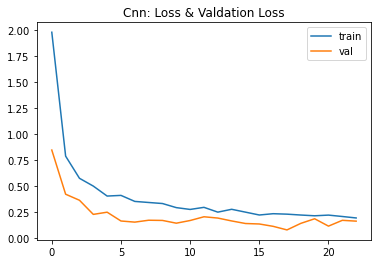

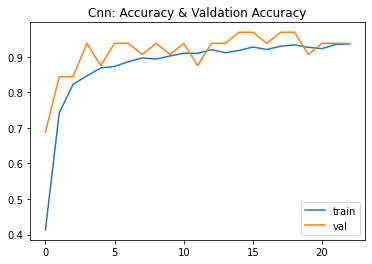

2/2 [==============================] - 0s 39ms/step


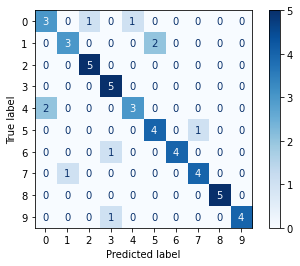

In [16]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('Cnn: Loss & Valdation Loss')
plt.legend()
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('Cnn: Accuracy & Valdation Accuracy')
plt.legend()
plt.show()

target_names = ["AFRICAN LEOPARD","CARACAL","CHEETAH","CLOUDED LEOPARD","JAGUAR","LIONS","OCELOT","PUMA","SNOW LEOPARD","TIGER"]
labels_names =[0,1,2,3,4,5,6,7,8,9]

Y_pred = model.predict(testdata)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(testdata.classes, y_pred, labels=labels_names)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
disp = disp.plot(cmap=plt.cm.Blues)

plt.show()


In [17]:
res_model = load_model("models/best_resnetmodel_BIGCATS.h5")
res_model.evaluate(testdata)

2/2 [==============================] - 1s 489ms/step - loss: 0.0333 - accuracy: 1.0000


[0.03334430605173111, 1.0]